# Streamgraph Twitter
This notebook takes you through making a streamgraph from tweets contained in '.csv' or '.json' files.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Intro/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.           

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook: 


- **nltk:** A leading platform for building Python programs to work with human language data.
- **string:** Contains a number of functions to process standard Python strings.
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **os:** Provides a portable way of using operating system dependent functionality.
- **csv:** Implements classes to read and write tabular data in CSV format.
- **json:** Allows for handling of data in JSON format.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
- **math:** Provides access to the mathematical functions defined by the C standard.
- **numpy:** The fundamental package for scientific computing with Python.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **scipy:** Open-source software for mathematics, science, and engineering. The SciPy library depends on NumPy, which provides convenient and fast N-dimensional array manipulation.
- **ggplot:** a Python implementation of the grammar of graphics.
- **zipfile:** Allows for handling of zipfiles.

In [2]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re
import os
import csv
import json
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rankdata
from ggplot import *
import zipfile

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We are doing this so you will not need to make changes in the code further down.

First we need to specify what file type our data is saved as. Generally when dealing with Twitter data it will be in either ".json" or ".csv" format. For this reason our notebook will only read in ".csv" or ".json" files. The first variable `fileType` is where you choose either ".csv" or ".json" for your `fileType`. So it should look like `fileType = ".csv"` or `fileType = ".json"`.

Your data can be contained in one file or many. Therefore, you need to state if you want to read in a single document or an entire directory. If you want to read in a single document, then set `singleDoc` equal to **True**. If you want to read in an entire directory of documents then set `singleDoc` equal to **False**.

The `interestedWords` variable is where you insert your words of interest. Make sure to put each word in quotes and separate them with a comma. Remember, you will see how often each word occurs in each chunk simultaneously, so too many words may make the graph hard to read.

The `freqDict` variable is an empty dictionary which will be filled with words and their frequencies further down in the code.

In [3]:
fileType = ".json"
singleDoc = False
interestedWords = ['gop', 'blame', 'trump']
freqDict = {}

#print(" ".join(stopwords.fileids()))

#### File paths
Here we are saving different file paths as variables that we need in our code. We again do this so you will not need to make as many changes to the code later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one, or we may need to access a file in this directory, but need to navigate to another folder to access other data. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names for the output in the appropriate cells down below. We save this file path as the variable `dataResults`.

Lastly, we use the file path from `dataHome` to point to the directory where our data is stored and save that as `dataRoot`. Notice though that this is dependent upon whether you chose `".json"` or `".csv"` as your `fileType` above.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
if fileType == ".csv":
    dataRoot = os.path.join(dataHome, "twitter", "CSV", "parkland")
else:
    dataRoot = os.path.join(dataHome, "twitter", "JSON")

### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you do't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

You should not need to make any changes as we use the same variables containing our file paths as above, so if you need to make adjustments to the file paths, you need to make them there, specifcally to the `dataRoot` variable.

In [5]:
direct = dataRoot
allZipFiles = glob.glob(os.path.join(dataRoot,"*.zip"))
for item in allZipFiles:
    fileName = os.path.splitext(direct)[0]
    zipRef = zipfile.ZipFile(item, "r")
    zipRef.extractall(fileName)
    zipRef.close()
    os.remove(item)

### Functions
We need to create a few functions in order to calculate and create a streamgraph. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Read a .csv file

This function gives parameters and statements for how to read a '.csv' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".csv"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are including that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we tell Python to seperate the lines using a comma as the delimiter. Next we add the lines as rows in a column. Finally, we return the the content starting with row 1, not row 0, as row 0 is the header.

In [6]:
if fileType == ".csv":
    def readTweets(filepath, textColIndex, encoding = 'utf-8'):

        with open(filepath, encoding = encoding) as f:

            reader = csv.reader(f, delimiter = ',', quotechar = '"')

            content = []
            for row in reader: 
                content.append(row[textColIndex])

            # skip header
            return content[1 : ]

#### Read a .json file

This function gives parameters and statements for how to read a '.json' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".json"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are including that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we use the `loads` function form the `json` package. This will read in the '.json' file content as a string and save it to the empty `data = []` list. Next we convert the `data` list to a pandas database. Next we sort the database by the `'created_at'` column so the dataframe is now in order by date. Then we convert a single column to a list based on what is chosen for the `textColIndex` variable later on in the code. Finally, we return the content starting with row 1, not row 0, as row 0 is the header. 

In [7]:
if fileType == ".json":
    def readTweets(filepath, textColIndex, encoding = 'utf-8', errors = 'ignore'):
        
        with open(filepath, encoding = encoding, errors = errors) as jsonData:
            data = []
            for line in jsonData:
                data.append(json.loads(line))
        jData = pd.DataFrame(data)
        jData['created_at']=pd.to_datetime(jData.created_at)
        jData = jData.sort_values(by='created_at')
        content = jData[textColIndex].tolist()

        return content[1 : ]

#### Text Cleaning
This next function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be considered two different words, so we make them all 'love'. Next we remove URLs by removing any text that starts with 'http' and ending with a space. Then we split the text into individual words. Next we remove any empty space and punctuation. Finally, we return a list of cleaned tweets.

In [8]:
def clean(text):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

### Read in the tweets

#### First set variables
Before we run the cell below, make sure the variables in the beginning of the notebook are set correctly. 

Next, make sure the variables in the following cell are set correctly. 

The `tweetFile` variable should contain the single file you wish to run if you are only interested in a single document. If you set `singleDoc` above to **False** then don't worry about the `tweetFile` variable. The `fileType` variable from above is automatically added to the end of the file name, so you do not need to add it. So if your file is named "myFile.csv" you only need to put "myFile" as the ".csv" is automatically added. 

Then we assign our `textColIndex` and `encoding` variables. The only one you will need to change is the `textColIndex` variable. You will need to assign the column containing the tweet content to this variable. You can either name it by index number (remembering to start counting at 0 and not 1) for '.csv' files or by the column header for '.json' files. To do it by index number you count from the left beginning with 0 and enter the number of the column you wish to process. If you want the first column, put 0, if the third column, put 2, and so on. If you wish to choose the column by the header, then put the header in quotes and set `textColIndex` equal to that header. It should look like this `textColIndex = 'text'`. You can change the `encoding` variable if you wish, but you may get errors relating to the encoding of your text if you do.  

Lastly, we need to decide how many tweets we want in a chunk. We do this by assigning a number to our `numTweetsPerChunk` variable. This is so we can see how word usage changes over the course of our tweets. This number is dependent on your data. If you have too many chunks, the graph is difficult to read. Try to keep the chunks to around 50 or less. So if you have 50,000 tweets, you'll want the chunks to be comprised of 1000 or more tweets, so assign 1000 to the `numTweetsPerChunk` variable. 

#### From a single text

If you set `singleDoc` above equal to **True**, then the first part of the script in the box below uses the functions and file paths we have created to break up all the tweets into separate chunks.

We start by pointing to the specific file.  

Then we implement the `readTweets` function we created above. Then we go through and count the tweets based on our `numTweetsPerChunk` variable. Then we count the chunks and assign each chunk to the empty list `chunks`. This creates a list of lists.

#### From multiple files in a directory

If you set `singleDoc` equal to **False**, then the second part of the script in the box below after `else:` now uses the functions and file paths we have created above to break up all the tweets into separate chunks.

We start by assigning an empty list to the variable `tweets`. This will be used to store the content of our documents as one list after we read it in.

Then we go through the directory our data is stored in. We assigned this directory to the `dataRoot` variable earlier. We the use our `readTweets` function and store the results in the empty list assigned to our `tweets` variable.

Then we go through and count the tweets based on our `numTweetsPerChunk` variable. Then we count the chunks and assign each chunk to the empty list `chunks`. This creates a list of lists.

In [9]:
tweetFile = 'parkland' + fileType
textColIndex = 'text'
encoding = 'ISO-8859-1'
numTweetsPerChunk = 1000

if singleDoc is True:
    
    filepath = os.path.join(dataRoot, tweetFile)

    tweets = readTweets(filepath, textColIndex, encoding)

    print('Read {} tweets'.format(len(tweets)))

    numberChunks = int(math.ceil(len(tweets) / numTweetsPerChunk))

    print('Tweets per chunk: {}, # chunks is {}'.format(numTweetsPerChunk, numberChunks))

    chunks = []

    for i in range(numberChunks - 1):

        chunks.append(tweets[i * numTweetsPerChunk : (i + 1) * numTweetsPerChunk])

    chunks.append(tweets[(i + 1) * numTweetsPerChunk : ])
else:
    tweets = []
    for root, subdirs, files in os.walk(dataRoot):
        
        for filename in files:
            
            # skip hidden file
            if filename.startswith('.'):
                continue
            
            dataFilepath = os.path.join(dataRoot, filename)
            
            content = readTweets(dataFilepath, textColIndex, encoding)
            tweets.extend(content)
            
            
            print('Read {} tweets'.format(len(tweets)))

            numberChunks = int(math.ceil(len(tweets) / numTweetsPerChunk))

            print('Tweets per chunk: {}, # chunks is {}'.format(numTweetsPerChunk, numberChunks))

            chunks = []

            for i in range(numberChunks - 1):

                chunks.append(tweets[i * numTweetsPerChunk : (i + 1) * numTweetsPerChunk])

            chunks.append(tweets[(i + 1) * numTweetsPerChunk : ])

Read 27056 tweets
Tweets per chunk: 1000, # chunks is 28


### Clean chunks

Here we tokenize the words in each list of our list of lists from above. We then apply our `clean` function to the tokenized lists and add them to the empty list `tokenBlocks`.

In [10]:
tokenBlocks = []

for c in chunks:
    
    blocks = ''.join(c)
    
    words = word_tokenize(blocks)
    
    words = clean(str(words))
    tokenBlocks.append(words)

### Count words in each chunk
Now we count each word of interest in each chunk and add them to out `freqDict` variable from above. This allows us to keep track of the separate word counts for each chunk.

In [11]:
# calculate frequency
for w in interestedWords:
    
    freqDict[w] = np.zeros(len(tokenBlocks)).tolist()
    
for idx, block in enumerate(tokenBlocks):
    
    for token in block:
        
        if token in freqDict:
            freqDict[token][idx] += 1

### Emulate R's stat_steamgraph in 'ggTimeSeries' package

This function is meant to emulate the stat_steamgraph function from the ggTimeSeries package in R. You will most likely not need to make any changes here. This function is creating a special data frame (kind of like an excel table) for ggplot to be able to read it in a way that it creates a streamgraph from the data.

In [12]:
def composeDataframe(freqDict, debug = False):

    if debug:
        df = pd.DataFrame(data = freqDict)
        print(df)
        print('\n' * 3)


    wordCol = []
    freqCol = []
    seqNum = []
    
    for word in freqDict:
        wordCol.extend([word] * len(freqDict[word]))
        freqCol.extend(freqDict[word])
        seqNum.extend(list(range(1, len(freqDict[word]) + 1)))

    dataDict = {"Term" : wordCol, "Freq" : freqCol, 'SeqNum' : seqNum}

    df = pd.DataFrame(data = dataDict)

    if debug:
        print(df)
        print('\n' * 3)

    rankdf = df.groupby(["Term"], as_index = False).agg({"Freq" : "std"}).rename(columns = {"Freq" : "Std"})

    if debug:
        print(df)
        print('\n' * 3)

    rankdf["StdRank"] = rankdata(rankdf["Std"], method = 'ordinal')

    if debug:
        print(rankdf)
        print('\n' * 3)

    for idx, row in rankdf.iterrows():

        if row["StdRank"] % 2 == 0:
            rankdf.at[idx, "StdRank"] = -row["StdRank"]


    if debug:
        print(rankdf)
        print('\n' * 3)

    df = df.merge(rankdf, on = 'Term')

    if debug:
        print(df)
        print('\n' * 3)

    df = df.sort_values(by = ['SeqNum', 'StdRank'])

    if debug:
        print(df)
        print('\n' * 3)

    def f(x):

        x["cumsum"] = x["Freq"].cumsum()
        x["ymax"] = x["Freq"].cumsum() - x["Freq"].sum() / 2
        x["ymin"] = x["ymax"] - x["Freq"]

        return x


    df = df.groupby(["SeqNum"], as_index = False).apply(f)

    if debug:
        print(df)
        print('\n' * 3)
        
    return df


Now we apply the `composeDataframe` function from above to our `freqDict` variable so we can plot the streamgraph in our next block of code.

In [13]:
df = composeDataframe(freqDict)

### Plot the Streamgraph

For the code below, you will only need to make changes to the `# Variables` section. We have these variables here so  you do not need to go searching through the code to find where to make these changes. In addition, some of these elements are used more than once, so by assigning them to a variable you only need to make the change once and it will be implemented in all the places the element is used. 

First we name the output file and assign that name to the variable `streamTwitterOutput`. It is currently saved as a '.svg' file, but you can also save it as a '.png' or '.jpg'. Then we decide the dimensions of the streamgraph. The variable names are self explanitory as far as the dimensions. Feel free to play with the dimensions until you get a `width` and `height` that work for you. Then we choose a resolution for our output and assign it to the variable `dpi`.

Next we choose the color palette for our streamgraph and assign it to the variable `color`. You may want to change the palette color to something else besides `'Dark2'`. Some color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf) under RColorBrewer. 

Now we choose the size of the font for our x axis, y axis, and main titles and assign the font size to the variable `fontSz`. Then we choose the angle of x tick labels and assign it to the variable `angle`. The `angle` variable can be any number between 0 and 360. Then the `hjust` changes the horizontal justification of the x tick labels and `vjust` changes the vertical justification of the x axis label. These numbers can be any number between -1 and 1.

Next you will want to change label of your x axis as well as the main title to match your data. To change the x axis label change the content of the `xlabel` varibale and to change the main title change the content of the `title` variable.

You should not need to make any adjustments after `# Plot`. Once you've made your changes, you're ready to plot your graph!

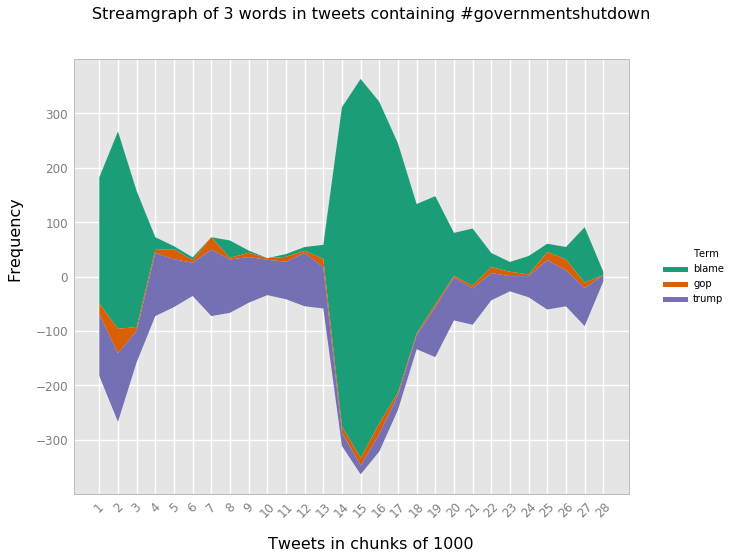

In [14]:
# Variables
streamTwitterOutput = "streamgraphTwitter.svg"
width = 14
height = 8
dpi = 300
color = 'Dark2'
fontSz = 16
angle = 45
hjust = 1
vjust = -0.02
xlabel = "Tweets in chunks of 1000"
title = "Streamgraph of 3 words in tweets containing #governmentshutdown"

# Plot
p = ggplot(df, aes(x = 'SeqNum', ymin = 'ymin', ymax = 'ymax', y = 'Freq', group = 'Term', fill = 'Term')) +\
    geom_ribbon() + \
    theme(axis_text_x = element_text(angle = angle, hjust = hjust)) + \
    scale_fill_brewer(type = 'qual', palette = color) + \
    xlab(element_text(text = xlabel, size = fontSz, vjust = vjust)) + \
    ylab(element_text(text = "Frequency", size = fontSz)) + \
    scale_x_continuous(breaks = list(range(1, len(tokenBlocks) + 1))) + \
    ggtitle(element_text(text = title, size = fontSz))
p.make()
plt.savefig(os.path.join(dataResults,streamTwitterOutput), width = width, height = height, dpi = dpi)

plt.show()

## VOILA!!